In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Copyright (c) 2020. ZZL
# @Time     : 2020/4/27
# @Author   : ZL.Z
# @Reference: None
# @Email    : zzl1124@mail.ustc.edu.cn
# @FileName : acoustic_feature.py
# @Software : Python3.6;PyCharm;Windows10
# @Hardware : Intel Core i7-4712MQ;NVIDIA GeForce 840M
# @Version  :  V1.1: 2020/5/15
#              1. 端点检测增加避免语音过短，比如出现只有一帧情况时产生bug
#              2. 增加librosa.load函数的音频采样率传入参数
#              3. 对能量值和求LPC所需值等，利用np.finfo(np.float64).eps，避免其值为0，防止后续取log和求LPC出错(eps是取非负的最小值)
#              4. 修复activity_detect中计算浊音段时由于最后数帧能量都超过阈值，程序只将起始帧加入列表，导致的浊音段为奇数的bug
#              V1.0: 2020/4/27-2020/5/9
# @License  : GPLv3
# @Brief    : 声学特征提取
import os
import subprocess
import numpy as np
import librosa
import librosa.display
from scipy.signal import lfilter, get_window
from scipy.stats import skew, kurtosis
import soundfile as sf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
matplotlib.rcParams['axes.unicode_minus'] = False  # 当坐标轴有负号的时候可以显示负号

In [2]:
def _print(bl=True, s=None):
    if bl:
        print(s)
    else:
        pass


def func_format(x, pos):
    return "%d" % (1000 * x)

### class OpenSmileFeatureSet

In [88]:
class OpenSmileFeatureSet:
    """利用openSmile工具进行特征提取"""
    dft_feature_file_save_path = os.getcwd()  # 默认特征集文件保存路径

    def __init__(self, input_file):
        """
        初始化
        :param input_file: 输入.wav音频文件，或是openSMILE所支持的文件格式
        """
        self.openSmile_path = ".\\openSMILE"
        self.input_file = input_file
        self.eGeMAPSv01a = ".\\config\\gemaps\\eGeMAPSv01a.conf"  # 2016-eGeMAPS特征集，共88个特征
        self.ComParE_2016 = ".\\config\\ComParE_2016.conf"  # 2016-ComParE特征集，共6373个特征
        self.IS09_emotion = ".\\config\\IS09_emotion.conf"  # 2009-InterSpeech Emotion Challenge特征集，共384个特征

    def feature_extraction(self, config_file, output_file):
        """
        利用openSmile工具特征提取
        :param config_file: 配置文件
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: None
        """
        #cmd = "SMILExtract -noconsoleoutput -C %s -I %s -O %s" % (config_file, self.input_file, output_file)
        cmd = "SMILExtract -C \"%s\" -I \"%s\" -O \"%s\"" % (config_file, self.input_file, output_file)
        subprocess.run(cmd, cwd=self.openSmile_path, shell=True)

    def get_eGeMAPS(self, output_file=os.path.join(dft_feature_file_save_path, "eGeMAPS.csv")):
        """
        提取eGeMAPS特征集中的88维特征，详见会议论文集（2016 IEEE trans on Affective Computing）：
        https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7160715
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 88维特征
        """
        self.feature_extraction(self.eGeMAPSv01a, output_file)
        features = self.feature_file_reader(output_file)
        return features

    def get_ComParE(self, output_file=os.path.join(dft_feature_file_save_path, "ComParE_2016.csv")):
        """
        提取ComParE_2016特征集中的6373维特征，详见InterSpeech挑战赛论文集（2016 Computational Paralinguistics ChallengE）：
        https://www.isca-speech.org/archive/Interspeech_2016/pdfs/0129.PDF
        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3664314/
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 6373维特征
        """
        self.feature_extraction(self.ComParE_2016, output_file)
        features = self.feature_file_reader(output_file)
        return features

    def get_IS09(self, output_file=os.path.join(dft_feature_file_save_path, "IS09_emotion.csv")):
        """
        提取IS09_emotion特征集中的384维特征，详见InterSpeech挑战赛论文集（The INTERSPEECH 2009 Emotion Challenge）：
        https://www.isca-speech.org/archive/archive_papers/interspeech_2009/papers/i09_0312.pdf
        :param output_file: 输出特征.csv文件（-O命令，默认ARFF格式），修改“-O”命令，输出openSMILE所支持的文件格式
        :return: 384维特征
        """
        self.feature_extraction(self.IS09_emotion, output_file)
        features = self.feature_file_reader(output_file)
        return features

    @staticmethod
    def feature_file_reader(feature_f):
        """
        读取生成的ARFF格式csv特征文件中特征值
        :param feature_f: ARFF格式csv特征文件
        :return: 特征
        """
        with open(feature_f) as f:
            last_line = f.readlines()[-1]  # ARFF格式csv文件最后一行包含特征数据
        features = last_line.split(",")
        features = np.array(features[1:-1], dtype="float64")  # 第2到倒数第二个为特征数据
        return features

### class Spectrogram

In [4]:
class Spectrogram:
    """声谱图（语谱图）特征"""
    def __init__(self, input_file, sr=None, frame_len=512, n_fft=None, win_step=2 / 3, window="hamming", preemph=0.97):
        """
        初始化
        :param input_file: 输入音频文件
        :param sr: 所输入音频文件的采样率，默认为None
        :param frame_len: 帧长，默认512个采样点(32ms,16kHz),与窗长相同
        :param n_fft: FFT窗口的长度，默认与窗长相同
        :param win_step: 窗移，默认移动2/3，512*2/3=341个采样点(21ms,16kHz)
        :param window: 窗类型，默认汉明窗
        :param preemph: 预加重系数,默认0.97
        """
        self.input_file = input_file
        self.wave_data, self.sr = librosa.load(self.input_file, sr=sr)  # 音频全部采样点的归一化数组形式数据
        self.wave_data = librosa.effects.preemphasis(self.wave_data, coef=preemph)  # 预加重，系数0.97
        self.window_len = frame_len  # 窗长512
        if n_fft is None:
            self.fft_num = self.window_len  # 设置NFFT点数与窗长相等
        else:
            self.fft_num = n_fft
        self.hop_length = round(self.window_len * win_step)  # 重叠部分采样点数设置为窗长的1/3（1/3~1/2）,即帧移(窗移)2/3
        self.window = window

    def get_magnitude_spectrogram(self):
        """
        获取幅值谱:fft后取绝对值
        :return: np.ndarray[shape=(1 + n_fft/2, n_frames), dtype=float32]，（257，全部采样点数/(512*2/3)+1）
        """
        # 频谱矩阵：行数=1 + n_fft/2=257，列数=帧数n_frames=全部采样点数/(512*2/3)+1（向上取整）
        # 快速傅里叶变化+汉明窗
        mag_spec = np.abs(librosa.stft(self.wave_data, n_fft=self.fft_num, hop_length=self.hop_length,
                                       win_length=self.window_len, window=self.window))
        return mag_spec

    def get_power_spectrogram(self):
        """
        获取功率谱（能量谱）：幅值谱平方
        :return: np.ndarray[shape=(1 + n_fft/2, n_frames), dtype=float32]，（257，全部采样点数/(512*2/3)+1）
        """
        pow_spec = np.square(self.get_magnitude_spectrogram())
        return pow_spec

    def get_log_power_spectrogram(self):
        """
        获取log尺度功率谱（能量谱）：幅值谱平方S(也就是功率谱),10 * log10(S / ref),其中ref指定为S的最大值
        :return: np.ndarray[shape=(1 + n_fft/2, n_frames), dtype=float32]，（257，全部采样点数/(512*2/3)+1）
        """
        log_pow_spec = librosa.amplitude_to_db(self.get_magnitude_spectrogram(), ref=np.max)  # 转换为log尺度
        return log_pow_spec

    def get_mel_spectrogram(self, n_mels=26):
        """
        获取Mel谱:
        :param n_mels: Mel滤波器组的滤波器数量，默认26
        :return: np.ndarray[shape=(n_mels, n_frames), dtype=float32]，（26，全部采样点数/(512*2/3)+1）
        """
        # 频谱矩阵：行数=n_mels=26，列数=帧数n_frames=全部采样点数/(512*2/3)+1（向上取整）
        # 快速傅里叶变化+汉明窗,Mel滤波器组的滤波器数量 = 26
        mel_spec = librosa.feature.melspectrogram(self.wave_data, self.sr, n_fft=self.fft_num,
                                                  hop_length=self.hop_length, win_length=self.window_len,
                                                  window=self.window, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec)  # 转换为log尺度
        return log_mel_spec

    def plot(self, fig=None, show=True, **kwargs):
        """
        绘制声谱图
        :param fig: 指定绘制何种声谱图，mag/pow/log_pow/mel,默认都绘制
        :param show: 默认最后调用plt.show()，显示图形
        :return: None
        """
        if fig == "mag":
            mag_spec = self.get_magnitude_spectrogram()
            librosa.display.specshow(mag_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="linear")
            plt.title("Magnitude Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7)
        elif fig == "pow":
            pow_spec = self.get_power_spectrogram()
            librosa.display.specshow(pow_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="linear")
            plt.title("Power Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7)
        elif fig == "log_pow":
            log_pow_spec = self.get_log_power_spectrogram()
            librosa.display.specshow(log_pow_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="log")
            plt.title("Log-Power Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7, format="%+02.0f dB")
        elif fig == "mel":
            mel_spec = self.get_mel_spectrogram(**kwargs)
            librosa.display.specshow(mel_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="mel")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.title("Log-Mel Spectrogram")
            plt.colorbar(shrink=0.7, format="%+02.0f dB")
        else:
            plt.figure(figsize=(16, 8))
            plt.subplot(2, 2, 1)
            mag_spec = self.get_magnitude_spectrogram()
            librosa.display.specshow(mag_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="linear")
            plt.title("Magnitude Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7)

            plt.subplot(2, 2, 2)
            pow_spec = self.get_power_spectrogram()
            librosa.display.specshow(pow_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="linear")
            plt.title("Power Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7)

            plt.subplot(2, 2, 3)
            log_pow_spec = self.get_log_power_spectrogram()
            librosa.display.specshow(log_pow_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="linear")
            plt.title("Log-Power Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            # plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7, format="%+02.0f dB")

            plt.subplot(2, 2, 4)
            mel_spec = self.get_mel_spectrogram(**kwargs)
            librosa.display.specshow(mel_spec, sr=self.sr, hop_length=self.hop_length, x_axis="s", y_axis="mel")
            plt.title("Log-Mel Spectrogram")
            plt.xlabel("Time/ms")
            plt.ylabel("Frequency/Hz")
            plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
            plt.colorbar(shrink=0.7, format="%+02.0f dB")

        plt.tight_layout()
        if show:
            plt.show()

### class RhythmFeatures

In [76]:
class RhythmFeatures:
    """韵律学特征"""
    def __init__(self, input_file, sr=None, frame_len=2205, n_fft=None, win_step=2 / 3, window="hamming"):
        """
        初始化
        :param input_file: 输入音频文件
        :param sr: 所输入音频文件的采样率，默认为None
        :param frame_len: 帧长，默认2205个采样点(50ms,44.1kHz),与窗长相同
        :param n_fft: FFT窗口的长度，默认与窗长相同
        :param win_step: 窗移，默认移动2/3，2205*2/3=341个采样点(33ms,44.1kHz)
        :param window: 窗类型，默认汉明窗
        """
        self.input_file = input_file
        self.frame_len = frame_len  # 帧长，单位采样点数
        self.wave_data, self.sr = librosa.load(self.input_file, sr=sr)
        self.window_len = frame_len  # 窗长
        if n_fft is None:
            self.fft_num = self.window_len  # 设置NFFT点数与窗长相等
        else:
            self.fft_num = n_fft
        self.win_step = win_step
        self.hop_length = round(self.window_len * win_step)  # 重叠部分采样点数设置为窗长的1/3（1/3~1/2）,即帧移(窗移)2/3
        self.window = window

    def lld(self, **kwargs):
        """
        LLDs（low level descriptors）指的是手工设计的一些低水平特征。
        LLDs一般是在一帧frame语音上进行的计算，是用来表示一帧语音的特征。
        :param kwargs: activity_detect参数
        :return: 浊音(1，n)、轻音段(1，2*n)、有效语音段持续时间(1，n)，单位ms,numpy.uint32
                基频F0，单位Hz、一阶、二阶差分(1，按列拉直提取非0元素后个数，>=n_frames),numpy.float32
                对数能量值、一阶、二阶差分(1，n_frames),numpy.float32
                短时能量、一阶、二阶差分(1，无加窗n_frames),numpy.float64
                过零率，单位次,uint32、一阶、二阶差分(1，无加窗n_frames),numpy.float64
                声压级，单位dB、一阶、二阶差分(1，无加窗n_frames),numpy.float64
        """
        duration_voiced, duration_unvoiced, duration_all = self.duration(**kwargs)
        f0, mag = self.pitch()
        f0 = f0.T[np.nonzero(f0.T)]  # 按列提取非0元素，组成一维数组
        f0_de = librosa.feature.delta(f0, width=3)
        f0_de2 = librosa.feature.delta(f0, width=3, order=2)
        energy = np.log(self.energy())
        energy_de = librosa.feature.delta(energy, width=3)
        energy_de2 = librosa.feature.delta(energy, width=3, order=2)
        ste = self.short_time_energy()
        ste_de = librosa.feature.delta(ste, width=3)
        ste_de2 = librosa.feature.delta(ste, width=3, order=2)
        zcr = self.zero_crossing_rate()
        zcr_de = librosa.feature.delta(zcr, width=3)
        zcr_de2 = librosa.feature.delta(zcr, width=3, order=2)
        spl = self.intensity()
        spl_de = librosa.feature.delta(spl, width=3)
        spl_de2 = librosa.feature.delta(spl, width=3, order=2)
        return (duration_voiced, duration_unvoiced, duration_all, f0, f0_de, f0_de2, energy, energy_de, energy_de2,
                ste, ste_de, ste_de2, zcr, zcr_de, zcr_de2, spl, spl_de, spl_de2)

    def hsf(self, **kwargs):
        """
        HSFs（high level statistics functions）是在LLDs的基础上做一些统计而得到的特征，比如均值，最值等。
        HSFs是对一段语音utterance上的多帧语音做统计，是用来表示一个utterance的特征。
        :param kwargs: lld参数:activity_detect参数
        :return: 1*120维HSFs特征,numpy.float64: 浊音/轻音/有效语音段duration的最小值/最大值/极差/均值/标准差（第0-14维）；
                 F0/F0_de/F0_de2的最小值/最大值/极差/均值/标准差/偏度/峰度（第15-35维）；
                 energy/energy_de/energy_de2的最小值/最大值/极差/均值/标准差/偏度/峰度（第36-56维）；
                 ste/ste_de/ste_de2的最小值/最大值/极差/均值/标准差/偏度/峰度（第57-77维）；
                 zcr/zcr_de/zcr_de2的最小值/最大值/极差/均值/标准差/偏度/峰度（第78-98维）；
                 spl/spl_de/spl_de2的最小值/最大值/极差/均值/标准差/偏度/峰度（第99-119维）
        """
        llds = self.lld(**kwargs)
        hsfs = []
        for i in range(len(llds)):
            hsfs = np.append(hsfs, [np.min(llds[i]), np.max(llds[i]),
                                    np.ptp(llds[i]), np.mean(llds[i]), np.std(llds[i])])
            if i > 2:  # 前3个为duration，不计算其偏度和峰度
                hsfs = np.append(hsfs, [skew(llds[i]), kurtosis(llds[i])])
        return hsfs

    def short_time_energy(self):
        """
        计算语音短时能量：每一帧中所有语音信号的平方和
        :return: 语音短时能量列表(值范围0-每帧归一化后能量平方和，这里帧长512，则最大值为512)，
        np.ndarray[shape=(1，无加窗，帧移为0的n_frames), dtype=float64]
        """
        energy = []  # 语音短时能量列表
        energy_sum_per_frame = 0  # 每一帧短时能量累加和
        for i in range(len(self.wave_data)):  # 遍历每一个采样点数据
            energy_sum_per_frame += self.wave_data[i] ** 2  # 求语音信号能量的平方和
            if (i + 1) % self.frame_len == 0:  # 一帧所有采样点遍历结束
                energy.append(energy_sum_per_frame)  # 加入短时能量列表
                energy_sum_per_frame = 0  # 清空和
            elif i == len(self.wave_data) - 1:  # 不满一帧，最后一个采样点
                energy.append(energy_sum_per_frame)  # 将最后一帧短时能量加入列表
        energy = np.array(energy)
        energy = np.where(energy == 0, np.finfo(np.float64).eps, energy)  # 避免能量值为0，防止后续取log出错(eps是取非负的最小值)
        return energy

    def zero_crossing_rate(self):
        """
        计算语音短时过零率：单位时间(每帧)穿过横轴（过零）的次数
        :return: 每帧过零率次数列表，np.ndarray[shape=(1，无加窗，帧移为0的n_frames), dtype=uint32]
        """
        zcr = []  # 语音短时过零率列表
        counting_sum_per_frame = 0  # 每一帧过零次数累加和，即过零率
        for i in range(len(self.wave_data)):  # 遍历每一个采样点数据
            if i % self.frame_len == 0:  # 开头采样点无过零，因此每一帧的第一个采样点跳过
                continue
            if self.wave_data[i] * self.wave_data[i - 1] < 0:  # 相邻两个采样点乘积小于0，则说明穿过横轴
                counting_sum_per_frame += 1  # 过零次数加一
            if (i + 1) % self.frame_len == 0:  # 一帧所有采样点遍历结束
                zcr.append(counting_sum_per_frame)  # 加入短时过零率列表
                counting_sum_per_frame = 0  # 清空和
            elif i == len(self.wave_data) - 1:  # 不满一帧，最后一个采样点
                zcr.append(counting_sum_per_frame)  # 将最后一帧短时过零率加入列表
        return np.array(zcr, dtype=np.uint32)

    def energy(self):
        """
        每帧内所有采样点的幅值平方和作为能量值
        :return: 每帧能量值，np.ndarray[shape=(1，n_frames), dtype=float64]
        """
        mag_spec = np.abs(librosa.stft(self.wave_data, n_fft=self.fft_num, hop_length=self.hop_length,
                                       win_length=self.frame_len, window=self.window))
        pow_spec = np.square(mag_spec)
        energy = np.sum(pow_spec, axis=0)
        energy = np.where(energy == 0, np.finfo(np.float64).eps, energy)  # 避免能量值为0，防止后续取log出错(eps是取非负的最小值)
        return energy

    def intensity(self):
        """
        计算声音强度，用声压级表示：每帧语音在空气中的声压级Sound Pressure Level(SPL)，单位dB
        公式：20*lg(P/Pref)，P为声压（Pa），Pref为参考压力(听力阈值压力)，一般为2.0*10-5 Pa
        这里P认定为声音的幅值：求得每帧所有幅值平方和均值，除以Pref平方，再取10倍lg
        :return: 每帧声压级，dB，np.ndarray[shape=(1，无加窗，帧移为0的n_frames), dtype=float64]
        """
        p0 = 2.0e-5  # 听觉阈限压力auditory threshold pressure: 2.0*10-5 Pa
        e = self.short_time_energy()
        spl = 10 * np.log10(1 / (np.power(p0, 2) * self.frame_len) * e)
        return spl

    def duration(self, **kwargs):
        """
        持续时间：浊音、轻音段持续时间，有效语音段持续时间,一段有效语音段由浊音段+浊音段两边的轻音段组成
        :param kwargs: activity_detect参数
        :return: np.ndarray[dtype=uint32],浊音shape=(1，n)、轻音段shape=(1，2*n)、有效语音段持续时间列表shape=(1，n)，单位ms
        """
        wav_dat_split_f, wav_dat_split, voiced_f, unvoiced_f = self.activity_detect(**kwargs)  # 端点检测
        duration_voiced = []  # 浊音段持续时间
        duration_unvoiced = []  # 轻音段持续时间
        duration_all = []  # 有效语音段持续时间
        if np.array(voiced_f).size > 1:  # 避免语音过短，只有一帧浊音段
            for voiced in voiced_f:  # 根据帧分割计算浊音段持续时间，两端闭区间
                duration_voiced.append(round((voiced[1] - voiced[0] + 1) * self.frame_len / self.sr * 1000))
        else:  # 只有一帧时
            duration_voiced.append(round(self.frame_len / self.sr * 1000))
        for unvoiced in unvoiced_f:  # 根据帧分割计算清音段持续时间，浊音段左侧左闭右开，浊音段右侧左开右闭
            duration_unvoiced.append(round((unvoiced[1] - unvoiced[0]) * self.frame_len / self.sr * 1000))
        if len(duration_unvoiced) <= 1:  # 避免语音过短，只有一帧浊音段
            duration_unvoiced.append(0)
        for i in range(len(duration_voiced)):  # 浊音段+浊音段两边的轻音段组成一段有效语音段
            duration_all.append(duration_unvoiced[i * 2] + duration_voiced[i] + duration_unvoiced[i * 2 + 1])
        return (np.array(duration_voiced, dtype=np.uint32), np.array(duration_unvoiced, dtype=np.uint32),
                np.array(duration_all, dtype=np.uint32))

    def pitch(self, ts_mag=0.25):
        """
        获取每帧音高，即基频，这里应该包括基频和各次谐波，最小的为基频（一次谐波），其他的依次为二次、三次...谐波
        各次谐波等于基频的对应倍数，因此基频也等于各次谐波除以对应的次数，精确些等于所有谐波之和除以谐波次数之和
        :param ts_mag: 幅值倍乘因子阈值，>0，大于np.average(np.nonzero(magnitudes)) * ts_mag则认为对应的音高有效,默认0.25
        :return: 每帧基频及其对应峰的幅值(>0)，
                 np.ndarray[shape=(1 + n_fft/2，n_frames), dtype=float32]，（257，全部采样点数/(512*2/3)+1）
        """
        mag_spec = np.abs(librosa.stft(self.wave_data, n_fft=self.fft_num, hop_length=self.hop_length,
                                       win_length=self.frame_len, window=self.window))
        # pitches:shape=(d,t)  magnitudes:shape=(d.t), Where d is the subset of FFT bins within fmin and fmax.
        # pitches[f,t] contains instantaneous frequency at bin f, time t
        # magnitudes[f,t] contains the corresponding magnitudes.
        # pitches和magnitudes大于maximal magnitude时认为是一个pitch，否则取0，maximal默认取threshold*ref(S)=1*mean(S, axis=0)
        pitches, magnitudes = librosa.piptrack(S=mag_spec, sr=self.sr, threshold=1.0, ref=np.mean,
                                               fmin=50, fmax=800)  # 基频最大可能范围50-800Hz
        ts = np.average(magnitudes[np.nonzero(magnitudes)]) * ts_mag
        pit_likely = pitches
        mag_likely = magnitudes
        pit_likely[magnitudes < ts] = 0
        mag_likely[magnitudes < ts] = 0
        return pit_likely, mag_likely

    def activity_detect(self, min_interval=10, e_low_multifactor=1.0, zcr_multifactor=1.0, pt=False):
        """
        利用短时能量，短时过零率，使用双门限法进行端点检测
        :param min_interval: 最小浊音间隔，默认10帧
        :param e_low_multifactor: 能量低阈值倍乘因子，默认1.0
        :param zcr_multifactor: 过零率阈值倍乘因子，默认1.0
        :param pt: 输出打印标志位，默认为False
        :return: 全部有效语音段:按帧分割后(list,n*2)、按全部采样点的幅值分割(np.ndarray[shape=(n, 采样值数), dtype=float32])、
                浊音段(list,n*2)、轻音段(list,n*2)
        """
        ste = self.short_time_energy()
        zcr = self.zero_crossing_rate()
        energy_average = sum(ste) / len(ste)  # 求全部帧的短时能量均值
        energy_high = energy_average / 4  # 能量均值的4分之一作为能量高阈值
        energy_low = (sum(ste[:5]) / 5 + energy_high / 5) * e_low_multifactor  # 前5帧能量均值+能量高阈值的5分之一作为能量低阈值
        zcr_threshold = sum(zcr) / len(zcr) * zcr_multifactor  # 过零率均值*zcr_multfactor作为过零率阈值
        voiced_sound = []  # 语音段的浊音部分
        voiced_sound_added = []  # 浊音扩充后列表
        wave_detected = []  # 轻音扩充后的最终列表
        # 首先利用能量高阈值energy_high进行初步检测，得到语音段的浊音部分
        add_flag = True  # 加入voiced_sound列表标志位
        for i in range(len(ste)):  # 遍历短时能量数据
            if len(voiced_sound) == 0 and add_flag and ste[i] >= energy_high:  # 第一次达到阈值
                voiced_sound.append(i)  # 加入列表
                add_flag = False  # 接下来禁止加入
            if (not add_flag) and ste[i] < energy_high:  # 直到未达到阈值，此时该阶段为一段浊音语音
                if i - voiced_sound[-1] <= 2:  # 检测帧索引间隔，去掉间隔小于2的索引，判断该段为噪音
                    voiced_sound = voiced_sound[:-1]  # 该段不加入列表
                else:  # 否则加入列表
                    voiced_sound.append(i)
                add_flag = True  # 继续寻找下一段浊音（下一个阈值）
            # 再次达到阈值，判断两个浊音间隔是否大于最小浊音间隔
            elif add_flag and ste[i] >= energy_high and i - voiced_sound[-1] > min_interval:
                voiced_sound.append(i)  # 大于，则分段，加入列表
                add_flag = False  # 接下来禁止加入
            elif add_flag and ste[i] >= energy_high and i - voiced_sound[-1] <= min_interval:
                voiced_sound = voiced_sound[:-1]  # 小于，则不分段，该段不加入列表
                add_flag = False  # 接下来禁止加入
            if (i == len(ste) - 1) and (len(voiced_sound) % 2 == 1):  # 当到达最后一帧，发现浊音段为奇数，则此时到最后一帧为浊音段
                if i - voiced_sound[-1] <= 2:  # 检测帧索引间隔，去掉间隔小于2的索引，判断该段为噪音
                    voiced_sound = voiced_sound[:-1]  # 该段不加入列表
                else:  # 否则加入列表
                    voiced_sound.append(i)
        _print(pt, "能量高阈值:{}，浊音段:{}".format(energy_high, voiced_sound))
        # 再通过能量低阈值energy_low在浊音段向两端进行搜索，超过energy_low便视为有效语音
        for j in range(len(voiced_sound)):  # 遍历浊音列表
            i_minus_flag = False  # i值减一标志位
            i = voiced_sound[j]  # 浊音部分帧索引
            if j % 2 == 1:  # 每段浊音部分的右边帧索引
                while i < len(ste) and ste[i] >= energy_low:  # 搜索超过能量低阈值的帧索引
                    i += 1  # 向右搜索
                voiced_sound_added.append(i)  # 搜索到则加入扩充列表，右闭
            else:  # 每段浊音部分的左边帧索引
                while i > 0 and ste[i] >= energy_low:  # 搜索超过能量低阈值的帧索引
                    i -= 1  # 向左搜索
                    i_minus_flag = True  # i值减一标志位置位
                if i_minus_flag:  # 搜索到则加入扩充列表，左闭
                    voiced_sound_added.append(i + 1)
                else:
                    voiced_sound_added.append(i)
        _print(pt, "能量低阈值:{}，浊音再次扩展后:{}".format(energy_low, voiced_sound_added))
        # 最后通过过零率对浊音扩充后列表向两端再次进行搜索，获取轻音部分
        for j in range(len(voiced_sound_added)):  # 遍历浊音扩充后列表
            i_minus_flag = False  # i值减一标志位
            i = voiced_sound_added[j]  # 浊音扩充后部分帧索引
            if j % 2 == 1:  # 每段浊音扩充部分的右边帧索引
                while i < len(zcr) and zcr[i] >= zcr_threshold:  # 搜索超过过零率阈值的帧索引
                    i += 1  # 向右搜索
                wave_detected.append(i)  # 搜索到则加入扩充列表，右开
            else:  # 每段浊音扩充部分的左边帧索引
                while i > 0 and zcr[i] >= zcr_threshold:  # 搜索超过过零率阈值的帧索引
                    i -= 1  # 向左搜索
                    i_minus_flag = True  # i值减一标志位置位
                if i_minus_flag:  # 搜索到则加入扩充列表，左闭
                    wave_detected.append(i + 1)
                else:
                    wave_detected.append(i)
        _print(pt, "过零率阈值:{}，轻音段增加后:{}".format(zcr_threshold, wave_detected))
        wave_data_detected_frame = []  # 端点检测后，以帧为单位的有效语音列表
        for index in range(len(wave_detected)):
            if index % 2 == 0:  # 按段分割成列表
                wave_data_detected_frame.append(wave_detected[index:index + 2])
            else:
                continue
        _print(pt, "分割后共{}段语音，按帧分割为{}".format(len(wave_data_detected_frame), wave_data_detected_frame))
        wave_data_detected = []  # 端点检测后，对应全部采样点的幅值列表，其中列表代表每个有效语音段
        for index in wave_data_detected_frame:
            try:
                wave_data_detected.append(self.wave_data[index[0] * int(self.frame_len):
                                                         index[1] * int(self.frame_len)])
            except IndexError:
                wave_data_detected.append(self.wave_data[index[0] * int(self.frame_len):-1])
        _print(pt, "分割后共{}段语音，按全部采样点的幅值分割为{}".format(len(wave_data_detected), wave_data_detected))
        if np.array(voiced_sound_added).size > 1:  # 避免语音过短，只有一帧浊音段
            voiced_frame = np.array(voiced_sound_added).reshape((-1, 2)).tolist()  # 按帧分割的浊音段
        else:  # 只有一帧时
            voiced_frame = np.array(voiced_sound_added).tolist()
        unvoiced_frame = []  # 按帧分割的轻音段
        for i in range(len(wave_detected)):  # 根据最终的扩充后列表和浊音段列表求得轻音段
            if wave_detected[i] < voiced_sound_added[i]:
                unvoiced_frame.append([wave_detected[i], voiced_sound_added[i]])
            elif wave_detected[i] > voiced_sound_added[i]:
                unvoiced_frame.append([voiced_sound_added[i], wave_detected[i]])
            else:
                unvoiced_frame.append([0, 0])
        return wave_data_detected_frame, wave_data_detected, voiced_frame, unvoiced_frame

    def plot(self, energy="ste", show=True):
        """
        绘制语音波形曲线和（短时）能量、过零率曲线叠加，log功率谱和基频、声压级曲线叠加图
        :param energy: "ste"短时能量，"energy"能量，默认"ste"
        :param show: 默认最后调用plt.show()，显示图形
        :return: None
        """
        plt.figure(figsize=(8, 6))
        # 以下绘制波形图
        wave_ax = host_subplot(211, axes_class=AA.Axes)  # type:AA.Axes
        wave_ax.set_title("Wave Form")
        aa = wave_ax.axis["left"]  # type:AA.axis_artist.AxisArtist
        aa.line.set_color("b")
        aa.major_ticks.set_color("b")
        aa.major_ticklabels.set_color("b")
        wave_ax.set_xticks([])
        audio_total_time = int(len(self.wave_data) / self.sr * 1000)  # 音频总时间ms
        wave_ax.set_xlim(0, audio_total_time)
        wave_ax.set_ylabel("Normalized Amplitude", c="b")
        wave_ax.set_ylim(-1, 1)
        x = np.linspace(0, audio_total_time, len(self.wave_data))  # 从0ms开始，到总时长结束，共采样点数
        wave_ax.plot(x, self.wave_data, c="b", lw=1, label="wave curve")  # 语音波形曲线
        wave_ax.axhline(y=0, c="pink", ls=":", lw=1)  # Y轴0线
        # 以下在波形曲线上叠加绘制(短时)能量曲线
        if energy == "ste":
            e = self.short_time_energy()
        elif energy == "energy":
            e = self.energy()
        else:
            raise ValueError("Incorrect energy type parameter input, choose from 'ste' or 'energy'.")
        e_ax = wave_ax.twinx()  # type:AA.Axes  # 共享X轴
        aa = e_ax.axis["right"]  # type:AA.axis_artist.AxisArtist
        aa.toggle(all=True)
        aa.line.set_color("r")
        aa.major_ticks.set_color("r")
        aa.major_ticklabels.set_color("r")
        e_ax.set_ylabel("Energy", c="r")
        e_ax.set_ylim(0, np.max(e))
        x = np.linspace(self.frame_len/self.sr*1000, audio_total_time, len(e))  # 从第1帧结束对应时间开始，到总时长结束
        x = np.append(0, x)  # 第1帧时间之前补一个点：（0,0）
        e = np.append(0, e)
        if energy == "ste":
            e_ax.plot(x, e, c="r", lw=1.5, label="short time energy")
        else:
            e_ax.plot(x, e, c="r", lw=1.5, label="energy")
        # 以下在波形曲线上再次叠加绘制过零率曲线
        zcr = self.zero_crossing_rate()
        zcr_ax = wave_ax.twinx()  # type:AA.Axes
        zcr_ax.axis["right"] = zcr_ax.get_grid_helper().new_fixed_axis(loc="right", axes=zcr_ax, offset=(45, 0))
        aa = zcr_ax.axis["right"]  # type:AA.axis_artist.AxisArtist
        aa.toggle(all=True)
        aa.line.set_color("g")
        aa.major_ticks.set_color("g")
        aa.major_ticklabels.set_color("g")
        zcr_ax.set_ylabel("Times of Zero Crossing", c="g")
        zcr_ax.set_ylim(0, np.max(zcr))
        x = np.linspace(self.frame_len / self.sr * 1000, audio_total_time, len(zcr))  # 从第1帧结束对应时间开始，到总时长结束
        x = np.append(0, x)  # 第1帧时间之前补一个点：（0,0）
        zcr = np.append(0, zcr)
        zcr_ax.plot(x, zcr, c="g", lw=1.5, label="zero crossing rate")
        wave_ax.legend(prop={'family': 'Times New Roman', 'size': 10}, loc="upper right",
                       framealpha=0.5, ncol=3, handletextpad=0.2, columnspacing=0.7)
        # 以下绘制灰度对数功率谱图
        spec = Spectrogram(self.input_file, self.sr, self.frame_len, self.fft_num, self.win_step, self.window, 0)
        log_power_spec = librosa.amplitude_to_db(spec.get_magnitude_spectrogram(), ref=np.max)
        log_power_spec_ax = host_subplot(212, axes_class=AA.Axes)  # type:AA.Axes
        log_power_spec_ax.set_title("Pitches on Log-Power Spectrogram")
        librosa.display.specshow(log_power_spec[:, 1:], cmap="gray_r", sr=self.sr,
                                 hop_length=self.hop_length, x_axis="s", y_axis="linear")
        log_power_spec_ax.set_xlabel("Time/ms")
        log_power_spec_ax.set_ylabel("Frequency/Hz")
        log_power_spec_ax.xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
        # 以下在灰度对数功率谱图上叠加绘制pitches中可能的基频F0点图
        pitches, mags = self.pitch()  # 获取每帧基频
        f0_likely = []  # 可能的基频F0
        for i in range(pitches.shape[1]):  # 按列遍历非0最小值，作为每帧可能的F0
            try:
                f0_likely.append(np.min(pitches[np.nonzero(pitches[:, i]), i]))
            except ValueError:
                f0_likely.append(np.nan)  # 当一列，即一帧全为0时，赋值最小值为nan
        f0_all = np.array(f0_likely)
        x = np.linspace(0.5 * self.hop_length / self.sr, audio_total_time / 1000, f0_all.size)
        y = f0_all
        f0_all_ax = log_power_spec_ax.twinx()  # type:AA.Axes  # 共享X轴
        aa = f0_all_ax.axis["right"]  # type:AA.axis_artist.AxisArtist
        aa.toggle(all=True)
        aa.line.set_color("r")
        aa.major_ticks.set_color("r")
        aa.major_ticklabels.set_color("r")
        f0_all_ax.set_ylabel("Pitches/Hz", c="r")
        f0_all_ax.set_ylim(50, 500)
        f0_all_ax.scatter(x, y, s=10, c="r", label="F0")
        # 以下在灰度对数功率谱图上叠加绘制声压级曲线
        spl = self.intensity()
        x = np.linspace(0.5 * self.frame_len / self.sr, audio_total_time / 1000, spl.size)
        y = spl
        spl_ax = log_power_spec_ax.twinx()  # type:AA.Axes  # 共享X轴
        spl_ax.axis["right"] = spl_ax.get_grid_helper().new_fixed_axis(loc="right", axes=spl_ax, offset=(45, 0))
        aa = spl_ax.axis["right"]  # type:AA.axis_artist.AxisArtist
        aa.toggle(all=True)
        aa.line.set_color("g")
        aa.major_ticks.set_color("g")
        aa.major_ticklabels.set_color("g")
        spl_ax.set_ylabel("Intensity(SPL)/dB", c="g")
        spl_ax.set_ylim(30, 100)
        spl_ax.plot(x, y, "g", lw=1.5, label="SPL")
        plt.legend(prop={'family': 'Times New Roman', 'size': 10}, loc="upper right",
                   framealpha=0.5, ncol=3, handletextpad=0.2, columnspacing=0.7)

        plt.tight_layout()
        if show:
            plt.show()
        
        return (e,zcr,pitches,mags,spl)
     
    def get_sample_features(self,index):
        self.wavet=self.wave_data
        self.wave_data=self.wave_data[index-self.frame_len//2:index+self.frame_len//2+1]
        self.plot()
        
        self.wave_data=self.wave

### class SpectrumFeatures

In [6]:
class SpectrumFeatures:
    """基于谱的相关特征"""
    def __init__(self, input_file, sr=None, frame_len=512, n_fft=None, win_step=2 / 3, window="hamming", preemph=0.97):
        """
        初始化
        :param input_file: 输入音频文件
        :param sr: 所输入音频文件的采样率，默认为None
        :param frame_len: 帧长，默认512个采样点(32ms,16kHz),与窗长相同
        :param n_fft: FFT窗口的长度，默认与窗长相同
        :param win_step: 窗移，默认移动2/3，512*2/3=341个采样点(21ms,16kHz)
        :param window: 窗类型，默认汉明窗
        :param preemph: 预加重系数,默认0.97
        """
        self.input_file = input_file
        self.frame_len = frame_len
        self.spec = Spectrogram(self.input_file, sr, self.frame_len, n_fft, win_step, window, preemph)
        self.wave_data, self.sr = self.spec.wave_data, self.spec.sr
        self.rym = RhythmFeatures(self.input_file, sr, self.frame_len, n_fft, win_step, window)
        self.energy = self.rym.energy()  # 获取每帧能量值

    def mfcc(self, n_mfcc=13, ceplifter=22, n_mels=26, replace_energy=True):
        """
        获取MFCC系数
        :param n_mfcc: 要获取的MFCC个数，默认13个
        :param ceplifter: 升倒谱系数，作用在最后的倒谱系数上，默认22个
        :param n_mels: Mel滤波器组的滤波器数量，默认26
        :param replace_energy:  是否将第0阶倒谱系数替换成帧能量的对数，默认替换
        :return: n_mfcc*3维MFCC特征，每一列为一个MFCC特征向量 np.ndarray[shape=(n_mfcc*3, n_frames), dtype=float32]
        """
        log_mel_spec = self.spec.get_mel_spectrogram(n_mels)  # 获取log-mel谱
        # 前13个MFCC系数，升倒谱系数22, shape=(n_mfcc, t)=(13, 帧数n_frames), 每一列为一个MFCC特征向量
        mfcc_f = librosa.feature.mfcc(S=log_mel_spec, n_mfcc=n_mfcc, lifter=ceplifter)  # log-mel谱DCT之后得到MFCC
        if replace_energy:
            mfcc_f[0, :] = np.log(self.energy)  # 将第0个MFCC系数替换成对数能量值
        mfcc_delta = librosa.feature.delta(mfcc_f, width=3)  # 一阶差分
        mfcc_delta2 = librosa.feature.delta(mfcc_f, width=3, order=2)  # 二阶差分
        mfcc_f = np.vstack((mfcc_f, mfcc_delta, mfcc_delta2))  # 整合成39维MFCC特征
        return mfcc_f

    def plot(self, show=True, **kwargs):
        """
        绘制MFCC特征图
        :param show: 默认最后调用plt.show()，显示图形
        :return: None
        """
        mfcc_f = self.mfcc(**kwargs)
        librosa.display.specshow(mfcc_f, sr=self.sr, x_axis="s")
        plt.title("MFCC")
        plt.xlabel("Time/ms")
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
        plt.colorbar(shrink=0.7)

        plt.tight_layout()
        if show:
            plt.show()

### class QualityFeatures

In [7]:
class QualityFeatures:
    """声音质量特征（音质）"""
    def __init__(self, input_file, sr=None, frame_len=512, n_fft=None, win_step=2 / 3, window="hamming"):
        """
        初始化
        :param input_file: 输入音频文件
        :param sr: 所输入音频文件的采样率，默认为None
        :param frame_len: 帧长，默认512个采样点(32ms,16kHz),与窗长相同
        :param n_fft: FFT窗口的长度，默认与窗长相同
        :param win_step: 窗移，默认移动2/3，512*2/3=341个采样点(21ms,16kHz)
        :param window: 窗类型，默认汉明窗
        """
        self.input_file = input_file
        self.frame_len = frame_len  # 帧长，单位采样点数
        self.wave_data, self.sr = librosa.load(self.input_file, sr=sr)
        self.n_fft = n_fft
        self.window_len = frame_len  # 窗长512
        self.win_step = win_step
        self.hop_length = round(self.window_len * win_step)  # 重叠部分采样点数设置为窗长的1/3（1/3~1/2）,即帧移(窗移)2/3
        self.window = window

    def formant(self, ts_e=0.01, ts_f_d=200, ts_b_u=2000):
        """
        LPC求根法估计每帧前三个共振峰的中心频率及其带宽
        :param ts_e: 能量阈值：默认当能量超过0.01时认为可能会出现共振峰
        :param ts_f_d: 共振峰中心频率下阈值：默认当中心频率超过200，小于采样频率一半时认为可能会出现共振峰
        :param ts_b_u: 共振峰带宽上阈值：默认低于2000时认为可能会出现共振峰
        :return: F1/F2/F3、B1/B2/B3,每一列为一帧 F1/F2/F3或 B1/B2/B3，np.ndarray[shape=(3, n_frames), dtype=float64]
        """
        _data = lfilter([1., 0.83], [1], self.wave_data)  # 预加重0.83：高通滤波器
        inc_frame = self.hop_length  # 窗移
        n_frame = int(np.ceil(len(_data) / inc_frame))  # 分帧数
        n_pad = n_frame * self.window_len - len(_data)  # 末端补零数
        _data = np.append(_data, np.zeros(n_pad))  # 无法整除则末端补零
        win = get_window(self.window, self.window_len, fftbins=False)  # 获取窗函数
        formant_frq = []  # 所有帧组成的第1/2/3共振峰中心频率
        formant_bw = []  # 所有帧组成的第1/2/3共振峰带宽
        rym = RhythmFeatures(self.input_file, self.sr, self.frame_len, self.n_fft, self.win_step, self.window)
        e = rym.energy()  # 获取每帧能量值
        e = e / np.max(e)  # 归一化
        for i in range(n_frame):
            f_i = _data[i * inc_frame:i * inc_frame + self.window_len]  # 分帧
            if np.all(f_i == 0):  # 避免上面的末端补零导致值全为0，防止后续求LPC线性预测误差系数出错(eps是取非负的最小值)
                f_i[0] = np.finfo(np.float64).eps
            f_i_win = f_i * win  # 加窗
            a = librosa.lpc(f_i_win, 8)  # 获取LPC线性预测误差系数，即滤波器分母多项式，阶数为 预期共振峰数3 *2+2，即想要得到F1-3
            rts = np.roots(a)  # 求LPC返回的预测多项式的根,为共轭复数对
            rts = np.array([r for r in rts if np.imag(r) >= 0])  # 只保留共轭复数对一半，即虚数部分为+或-的根
            rts = np.where(rts == 0, np.finfo(np.float64).eps, rts)  # 避免值为0，防止后续取log出错(eps是取非负的最小值)
            ang = np.arctan2(np.imag(rts), np.real(rts))  # 确定根对应的角(相位）
            # F(i) = ang(i)/(2*pi*T) = ang(i)*f/(2*pi)
            frq = ang * (self.sr / (2 * np.pi))  # 将以角度表示的rad/sample中的角频率转换为赫兹sample/s
            indices = np.argsort(frq)  # 获取frq从小到大排序索引
            frequencies = frq[indices]  # frq从小到大排序
            # 共振峰的带宽由预测多项式零点到单位圆的距离表示: B(i) = -ln(r(i))/(pi*T) = -ln(abs(rts[i]))*f/pi
            bandwidths = -(self.sr / np.pi) * np.log(np.abs(rts[indices]))
            formant_f = []  # F1/F2/F3
            formant_b = []  # B1/B2/B3
            if e[i] > ts_e:  # 当能量超过ts_e时认为可能会出现共振峰
                # 采用共振峰频率大于ts_f_d小于self.sr/2赫兹，带宽小于ts_b_u赫兹的标准来确定共振峰
                for j in range(len(frequencies)):
                    if (ts_f_d < frequencies[j] < self.sr/2) and (bandwidths[j] < ts_b_u):
                        formant_f.append(frequencies[j])
                        formant_b.append(bandwidths[j])
                # 只取前三个共振峰
                if len(formant_f) < 3:  # 小于3个，则补nan
                    formant_f += ([np.nan] * (3 - len(formant_f)))
                else:  # 否则只取前三个
                    formant_f = formant_f[0:3]
                formant_frq.append(np.array(formant_f))  # 加入帧列表
                if len(formant_b) < 3:
                    formant_b += ([np.nan] * (3 - len(formant_b)))
                else:
                    formant_b = formant_b[0:3]
                formant_bw.append(np.array(formant_b))
            else:  # 能量过小，认为不会出现共振峰，此时赋值为nan
                formant_frq.append(np.array([np.nan, np.nan, np.nan]))
                formant_bw.append(np.array([np.nan, np.nan, np.nan]))
        formant_frq = np.array(formant_frq).T
        formant_bw = np.array(formant_bw).T
        # print(formant_frq.shape, np.nanmean(formant_frq, axis=1))
        # print(formant_bw.shape, np.nanmean(formant_bw, axis=1))
        return formant_frq, formant_bw

    def jitter(self):
        """
        计算频率微扰：描述相邻周期之间声波基本频率变化的物理量，主要反映粗糙声程度，其次反映嘶哑声程度
        相邻基频周期之间差的绝对值平均（绝对频率微扰）；相邻基频周期之间差的绝对值平均再除以平均周期（相对频率微扰）
                                                   N-1
        绝对频率微扰(s)：Jitter(absolute) = 1/(N-1) * ∑|T(i) - T(i+1)|
                                                   i=1             N
        相对频率微扰(%)：Jitter(relative) = Jitter(absolute) / (1/N * ∑T(i))
                                                                   i=1
        其中 T(i) 是第i个F0周期， N是总共的F0周期数
        参考：Farrús, Mireia, Javier Hernando, and Pascual Ejarque. "Jitter and shimmer measurements for speaker
        recognition." Eighth annual conference of the international speech communication association. 2007.
        :return: Jitter(absolute)，s、Jitter(relative)，%小数表示(结果介于0-2，即0-200%）
                numpy.float64
        """
        rym = RhythmFeatures(self.input_file, self.sr, self.frame_len, self.n_fft, self.win_step, self.window)
        pitches, mags = rym.pitch()
        f0_all = pitches.T[pitches.T > 0]  # 获取全部有效基频一维列表
        jitter_sum = 0
        for i in range(len(f0_all)):  # 累计求和
            if i < len(f0_all) - 1:
                jitter_sum += np.abs(1 / f0_all[i] - 1 / f0_all[i + 1])
        jitter_absolute = jitter_sum / (len(f0_all) - 1)  # 绝对频率微扰
        period_avg = np.average(1 / f0_all)  # 平均周期
        jitter_relative = jitter_absolute / period_avg  # 相对频率微扰
        return jitter_absolute, jitter_relative

    def shimmer(self):
        """
        计算振幅微扰：描述相邻周期之间声波幅度变化的物理量，主要反映嘶哑声程度
        相邻基频周期之间幅值比的20倍以10为底log的绝对值平均（绝对振幅微扰dB）；相邻振幅之差的绝对值平均再除以平均振幅（相对振幅微扰）
                                                     N-1
        绝对振幅微扰(dB)：shimmer(absolute) = 1/(N-1) * ∑|20 * lg(A(i+1) / A(i))|
                                                     i=1
                                                     N-1                        N
        相对振幅微扰(%)：shimmer(relative) = (1/(N-1) * ∑|A(i) - A(i+1)|) / (1/N * ∑A(i))
                                                     i=1                        i=1
        其中 A(i) 是第i个声波幅值， N是总共的F0周期数，与幅值数相同
        参考：Farrús, Mireia, Javier Hernando, and Pascual Ejarque. "Jitter and shimmer measurements for speaker
        recognition." Eighth annual conference of the international speech communication association. 2007.
        :return: shimmer(absolute)，dB、shimmer(relative)，%小数表示(结果介于0-2，即0-200%）
                numpy.float64
        """
        rym = RhythmFeatures(self.input_file, self.sr, self.frame_len, self.n_fft, self.win_step, self.window)
        pitches, mags = rym.pitch()
        mags_all = mags.T[mags.T > 0]  # 获取全部有效振幅一维列表
        shimmer_sum = 0
        shimmer_sum_db = 0
        for i in range(len(mags_all)):  # 累计求和
            if i < len(mags_all) - 1:
                shimmer_sum += np.abs(mags_all[i] - mags_all[i + 1])
                shimmer_sum_db += np.abs(20 * np.log10(mags_all[i + 1] / mags_all[i]))
        shimmer_absolute = shimmer_sum / (len(mags_all) - 1)  # 绝对振幅微扰
        shimmer_absolute_db = shimmer_sum / (len(mags_all) - 1)  # 绝对振幅微扰，以dB为单位
        period_avg = np.average(mags_all)  # 平均振幅
        shimmer_relative = shimmer_absolute / period_avg  # 相对振幅微扰
        return shimmer_absolute_db, shimmer_relative

    def plot(self, show=True):
        """
        绘制语音波形曲线和log功率谱、共振峰叠加图
        :param show: 默认最后调用plt.show()，显示图形
        :return: None
        """
        plt.figure(figsize=(8, 6))
        # 以下绘制波形图
        plt.subplot(2, 1, 1)
        plt.title("Wave Form")
        plt.ylabel("Normalized Amplitude")
        plt.xticks([])
        audio_total_time = int(len(self.wave_data) / self.sr * 1000)  # 音频总时间ms
        plt.xlim(0, audio_total_time)
        plt.ylim(-1, 1)
        x = np.linspace(0, audio_total_time, len(self.wave_data))
        plt.plot(x, self.wave_data, c="b", lw=1)  # 语音波形曲线
        plt.axhline(y=0, c="pink", ls=":", lw=1)  # Y轴0线
        # 以下绘制灰度对数功率谱图
        plt.subplot(2, 1, 2)
        spec = Spectrogram(self.input_file, self.sr, self.frame_len, self.n_fft, self.win_step, self.window, 0.83)
        log_power_spec = librosa.amplitude_to_db(spec.get_magnitude_spectrogram(), ref=np.max)
        librosa.display.specshow(log_power_spec[:, 1:], sr=self.sr, hop_length=self.hop_length,
                                 x_axis="s", y_axis="linear", cmap="gray_r")
        plt.title("Formants on Log-Power Spectrogram")
        plt.xlabel("Time/ms")
        plt.ylabel("Frequency/Hz")
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(func_format))
        # 以下在灰度对数功率谱图上叠加绘制共振峰点图
        formant_frq, __ = self.formant()  # 获取每帧共振峰中心频率
        color_p = {0: ".r", 1: ".y", 2: ".g"}  # 用不同颜色绘制F1-3点，对应红/黄/绿
        # X轴为对应的时间轴ms 从第0帧中间对应的时间开始，到总时长结束，间距为一帧时长
        x = np.linspace(0.5 * self.hop_length / self.sr, audio_total_time / 1000, formant_frq.shape[1])
        for i in range(formant_frq.shape[0]):  # 依次绘制F1/F2/F3
            plt.plot(x, formant_frq[i, :], color_p[i], label="F" + str(i + 1))
        plt.legend(prop={'family': 'Times New Roman', 'size': 10}, loc="upper right",
                   framealpha=0.5, ncol=3, handletextpad=0.2, columnspacing=0.7)

        plt.tight_layout()
        if show:
            plt.show()

### class VAD

In [8]:
class VAD:
    """语音端点检测"""
    def __init__(self, wav_file, frame_len=400, min_interval=15, e_low_multifactor=1.0, zcr_multifactor=1.0, pt=True):
        """
        初始化函数
        语音信号是非平稳信号，但是可以认为10~30ms的时间范围内，语音信号是平稳信号,比如这里我取25ms作为一帧
        此时一帧包含25ms*采样率(16kHz)*通道数（1）=400个采样点
        :param wav_file: 输入.wav音频文件
        :param frame_len: 帧长，默认400个采样点
        :param min_interval: 最小浊音间隔，默认15帧
        :param e_low_multifactor: 能量低阈值倍乘因子，默认1.0
        :param zcr_multifactor: 过零率阈值倍乘因子，默认1.0
        :param pt: 输出打印标志位，默认为True
        """
        rf = RhythmFeatures(wav_file, None, frame_len)
        self.wave_data = rf.wave_data  # 获取音频全部采样点的数组形式数据,每个采样点类型为np.float32
        self.sampling_rate = rf.sr
        self.frame_len_samples = frame_len  # 帧长，单位采样点数
        self.frame_len_time = round(self.frame_len_samples * 1000 / self.sampling_rate)  # 帧长，单位ms
        self.energy = rf.short_time_energy()  # 获取短时能量
        self.zcr = rf.zero_crossing_rate()  # 获取过零率
        # 获取端点检测后的有效语音段
        self.wav_dat_split_f, self.wav_dat_split, self.voiced_f, self.unvoiced_f = \
            rf.activity_detect(min_interval, e_low_multifactor, zcr_multifactor, pt)
        # 语音首尾端点检测，中间不检测
        if len(self.wav_dat_split_f[-1]) > 1:  # 避免语音过短，只有一帧
            self.wav_dat_utterance = self.wave_data[self.wav_dat_split_f[0][0] * int(self.frame_len_samples):
                                                    self.wav_dat_split_f[-1][1] * int(self.frame_len_samples)]
        else:  # 只有一帧时
            self.wav_dat_utterance = self.wave_data[self.wav_dat_split_f[0][0] * int(self.frame_len_samples):]

    def plot(self):
        """
        绘制音频波形、短时能量和过零率曲线
        :return: None
        """
        audio_total_time = int(len(self.wave_data) / self.sampling_rate * 1000)  # 音频总时间
        plt.figure(figsize=(16, 6))
        # 以下绘制短时能量曲线
        plt.subplot(1, 3, 2)
        frames = [i for i in range(0, len(self.energy))]  # 横轴为帧数轴
        plt.title("Short Time Energy")
        plt.xlabel("Frames")
        plt.ylabel("Energy")
        plt.plot(frames, self.energy, c="g", lw=1)
        plt.grid()
        # 以下绘制过零率曲线
        plt.subplot(1, 3, 3)
        frames = [i for i in range(0, len(self.zcr))]  # 横轴为帧数轴
        plt.title("Zero Crossing Rate")
        plt.xlabel("Frames")
        plt.ylabel("Times of Zero Crossing")
        plt.plot(frames, self.zcr, c="r", lw=1)
        plt.grid()
        # 以下绘制语音波形曲线+端点检测分割线
        plt.subplot(1, 3, 1)
        plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        time = [int(i * (audio_total_time / len(self.wave_data))) for i in range(0, len(self.wave_data))]
        plt.title("Wave Form")
        plt.xlabel("Time/ms")
        plt.ylabel("Normalized Amplitude")
        plt.ylim(-1, 1)
        plt.plot(time, self.wave_data, c="b", lw=1)  # 语音波形曲线
        c = "g"
        for i in range(len(self.wav_dat_split_f)):  # 端点检测分割线
            for j in range(len(self.wav_dat_split_f[i])):
                if (i == 0 and j == 0) or (i == len(self.wav_dat_split_f) - 1 and j == 1):
                    plt.axvline(x=self.wav_dat_split_f[i][j] * self.frame_len_time, c=c, ls="-", lw=2)
                else:
                    plt.axvline(x=self.wav_dat_split_f[i][j] * self.frame_len_time, c=c, ls="--", lw=1.5)
            if c == "r":
                c = "g"
            else:
                c = "r"
        plt.grid()

        plt.tight_layout()
        plt.show()

In [9]:
def my_acoustic_features(input_file, sr=None, frame_len=512, n_fft=None, win_step=2 / 3, window="hamming",
                         preemph=0.97, **kwargs):
    """
    主要利用librosa提取的各种声学特征,HSFs
    :param input_file: 输入音频文件
    :param sr: 所输入音频文件的采样率，默认为None
    :param frame_len: 帧长，默认512个采样点(32ms,16kHz),与窗长相同
    :param n_fft: FFT窗口的长度，默认与窗长相同
    :param win_step: 窗移，默认移动2/3，512*2/3=341个采样点(21ms,16kHz)
    :param window: 窗类型，默认汉明窗
    :param preemph: 预加重系数,默认0.97
    :param kwargs: RhythmFeatures类activity_detect方法参数
    :return: 1*523维HSFs特征,numpy.float64: 韵律学特征：120维HSFs（第0-119维，详见RhythmFeatures类hsf方法）；
             基于谱的相关特征(39*7维)：39维MFCC特征的最小值/最大值/极差/均值/标准差/偏度/峰度（第120-392维）；
             声音质量特征((3*6)*7+4维)：3个共振峰中心频率F1/F2/F3的最小值/最大值/极差/均值/标准差/偏度/峰度（第393-413维）；
             F1/F2/F3一阶差分的最小值/最大值/极差/均值/标准差/偏度/峰度（第414-434维）；
             F1/F2/F3二阶差分的最小值/最大值/极差/均值/标准差/偏度/峰度（第435-455维）；
             3个共振峰中心频率对应的带宽B1/B2/B3的最小值/最大值/极差/均值/标准差/偏度/峰度（第456-476维）；
             B1/B2/B3一阶差分的最小值/最大值/极差/均值/标准差/偏度/峰度（第477-497维）；
             B1/B2/B3二阶差分的最小值/最大值/极差/均值/标准差/偏度/峰度（第498-518维）；
             绝对/相对频率微扰、绝对/相对振幅微扰（第519-522维）
    """
    my_features = []
    # 韵律学特征
    rhythm_features = RhythmFeatures(input_file, sr, frame_len, n_fft, win_step, window)
    my_features = np.append(my_features, rhythm_features.hsf(**kwargs))  # 120维HSFs
    # 基于谱的相关特征
    spectrum_features = SpectrumFeatures(input_file, sr, frame_len, n_fft, win_step, window, preemph)
    mfcc = spectrum_features.mfcc(n_mfcc=13, ceplifter=22, n_mels=26, replace_energy=True)  # 39维MFCC特征
    lld_mfcc = [i for i in mfcc]  # 每一维作为LLDs
    # 声音质量特征
    quality_features = QualityFeatures(input_file, sr, frame_len, n_fft, win_step, window)
    fmt_frq, fmt_bw = quality_features.formant(ts_e=0.01, ts_f_d=200, ts_b_u=2000)  # 3个共振峰中心频率及其带宽
    # 第一共振峰中心频率及其带宽，并去除nan值
    fmt_f1, fmt_b1 = fmt_frq[0, :][~np.isnan(fmt_frq[0, :])], fmt_bw[0, :][~np.isnan(fmt_frq[0, :])]
    fmt_f1_d, fmt_b1_d = librosa.feature.delta(fmt_f1, width=3), librosa.feature.delta(fmt_b1, width=3)
    fmt_f1_d2, fmt_b1_d2 = librosa.feature.delta(fmt_f1, width=3, order=2), librosa.feature.delta(fmt_b1, width=3, order=2)
    # 第二共振峰中心频率及其带宽，并去除nan值
    fmt_f2, fmt_b2 = fmt_frq[1, :][~np.isnan(fmt_frq[1, :])], fmt_bw[1, :][~np.isnan(fmt_frq[1, :])]
    fmt_f2_d, fmt_b2_d = librosa.feature.delta(fmt_f2, width=3), librosa.feature.delta(fmt_b2, width=3)
    fmt_f2_d2, fmt_b2_d2 = librosa.feature.delta(fmt_f2, width=3, order=2), librosa.feature.delta(fmt_b2, width=3,
                                                                                                  order=2)
    # 第三共振峰中心频率及其带宽，并去除nan值
    fmt_f3, fmt_b3 = fmt_frq[2, :][~np.isnan(fmt_frq[2, :])], fmt_bw[2, :][~np.isnan(fmt_frq[2, :])]
    fmt_f3_d, fmt_b3_d = librosa.feature.delta(fmt_f3, width=3), librosa.feature.delta(fmt_b3, width=3)
    fmt_f3_d2, fmt_b3_d2 = librosa.feature.delta(fmt_f3, width=3, order=2), librosa.feature.delta(fmt_b3, width=3,
                                                                                                  order=2)
    jit_abs, jit_rel = quality_features.jitter()  # 全局特征：频率微扰
    shi_abs, shi_rel = quality_features.shimmer()  # 全局特征：振幅微扰
    lld_fmt = [fmt_f1, fmt_f2, fmt_f3, fmt_f1_d, fmt_f2_d, fmt_f3_d, fmt_f1_d2, fmt_f2_d2, fmt_f3_d2,
               fmt_b1, fmt_b2, fmt_b3, fmt_b1_d, fmt_b2_d, fmt_b3_d, fmt_b1_d2, fmt_b2_d2, fmt_b3_d2]
    lld = lld_mfcc + lld_fmt
    hsf = []
    for i in range(len(lld)):  # 基于帧特征LLDs计算全局特征HSFs
        hsf = np.append(hsf, [np.min(lld[i]), np.max(lld[i]), np.ptp(lld[i]), np.mean(lld[i]),
                              np.std(lld[i]), skew(lld[i]), kurtosis(lld[i])])
    my_features = np.append(my_features, np.append(hsf, [jit_abs, jit_rel, shi_abs, shi_rel]))  # 组合成1*523维全局特征
    return my_features

## Test
#### import data

In [114]:
current_path = os.getcwd()
wave_file = os.path.join(current_path, "audios\\wings.wav")
wave_file_vad = wave_file.split(".")[0] + "_vad.wav"
feature_file = os.path.join(current_path, "features\\feature.csv")

np.set_printoptions(threshold=np.inf)
#### 端点检测

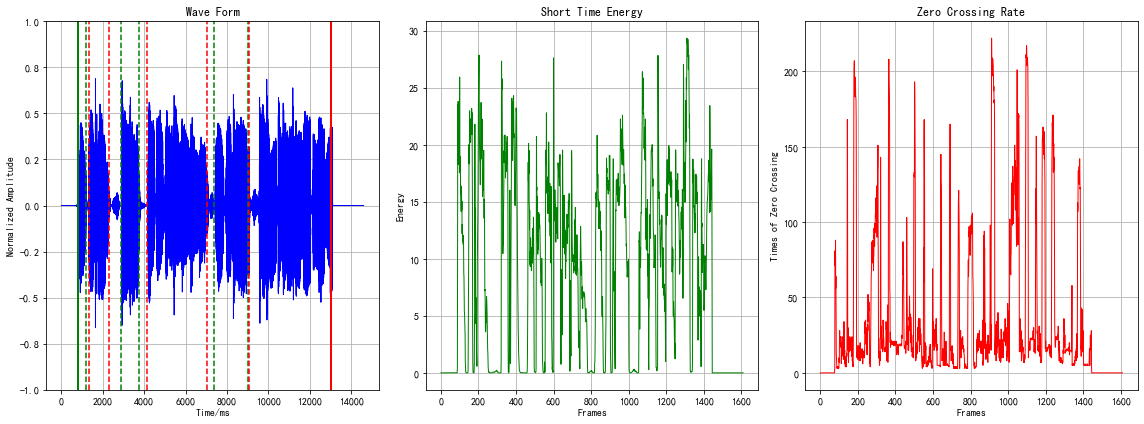

In [93]:
vad = VAD(wave_file, min_interval=15, pt=False)
sf.write(wave_file_vad, vad.wav_dat_utterance, 44100, "PCM_16")
vad.plot()

In [115]:
wave_data,_=librosa.load(wave_file, sr=44100)
path1=wave_file.split(".")[0] + "_1.wav"
path2=wave_file.split(".")[0] + "_2.wav"
sf.write(path1,wave_data[44000:44000+2205*2],44100,"PCM_16")
sf.write(path2,wave_data[44000+2205*2:44000+2205*4],44100,"PCM_16")

D:\Software\Python36x64\jupyter projects\sequential\audios\wings.wav D:\Software\Python36x64\jupyter projects\sequential\features\feature.csv


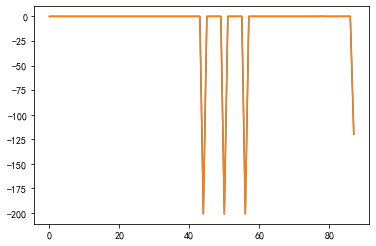

In [116]:
# 利用openSmile工具进行特征提取
print(wave_file,feature_file)
opensmile_f = OpenSmileFeatureSet(path1)
feat = opensmile_f.get_eGeMAPS(feature_file)
feature1=opensmile_f.feature_file_reader(feature_file)
opensmile_f = OpenSmileFeatureSet(path2)
feat = opensmile_f.get_eGeMAPS(feature_file)
#print(feat.shape, feat.dtype, feat)
feature2=opensmile_f.feature_file_reader(feature_file)
#print(feature1)
#print(feature2)
plt.plot([i for i in range(88)],feature1)
plt.plot([i for i in range(88)],feature2)

In [95]:
sf.write()

[ 4.241401e+01  1.526828e-01  3.777945e+01  4.237779e+01  4.698187e+01
  9.202423e+00  8.353608e+01  1.083596e+02  8.325362e+01  6.963571e+01
  1.658233e+00  7.544044e-01  2.213735e-01  1.677364e+00  2.884446e+00
  2.663073e+00  1.899527e+01  1.333921e+01  9.646672e+00  4.814908e+00
  8.516620e-01  1.048173e+00  1.350943e+01  1.520181e+00 -2.622379e+00
 -7.350605e+00 -5.247470e+00 -4.159719e+00 -2.003972e+01 -1.052201e+00
  2.169873e-02  2.062366e+00  7.658357e-01  1.135650e+00  1.034084e+01
  7.432715e-01  5.371032e+00  2.342867e+00  1.904751e+01  8.465615e-01
  7.559981e+02  2.967219e-01  1.222339e+03  2.459638e-01 -7.383338e+01
 -1.187487e+00  1.805407e+03  1.794163e-01  8.319689e+02  4.388356e-01
 -6.780215e+01 -1.159140e+00  3.013457e+03  1.435298e-01  7.179136e+02
  5.712103e-01 -7.216837e+01 -1.047374e+00 -1.104048e+01 -1.208763e+00
  2.213626e+01  6.573055e-01  9.244173e-02  4.815555e-01 -1.837238e-02
 -9.910836e-01  1.067466e+00  8.277711e-01  1.952199e+01  9.778830e-01
 -4.77

In [ ]:
# 常用声学特征
# my_acoustic_f = my_acoustic_features(wave_file_vad)
# print(my_acoustic_f.shape, my_acoustic_f.dtype, my_acoustic_f)

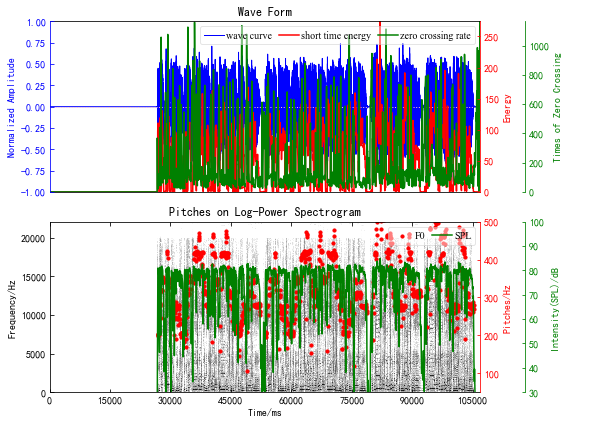

In [117]:
# 韵律学特征
rhythm_f = RhythmFeatures(wave_file,win_step=1)
e,zcr,pitches,mags,spl=rhythm_f.plot()

In [122]:
print(len(e))
print(len(zcr))
print(len(pitches))
print(len(mags))
print(len(spl))
print(np.where(e>1))

2140
2140
1103
1103
2139
(array([ 537,  538,  539, ..., 2103, 2104, 2105], dtype=int64),)


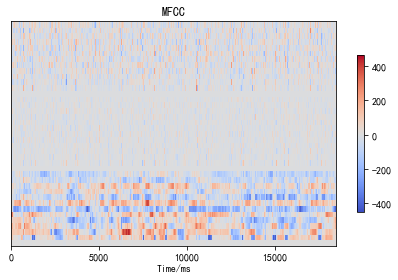

In [23]:
# 基于谱的相关特征
spectrum_f = SpectrumFeatures(wave_file_vad)
spectrum_f.plot()

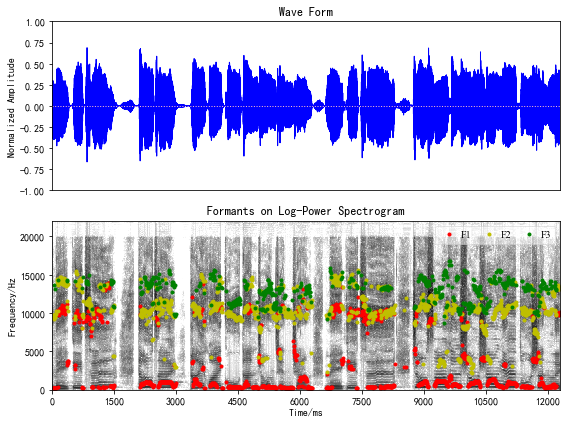

In [24]:
# 音质特征
quality_f = QualityFeatures(wave_file_vad)
quality_f.plot()

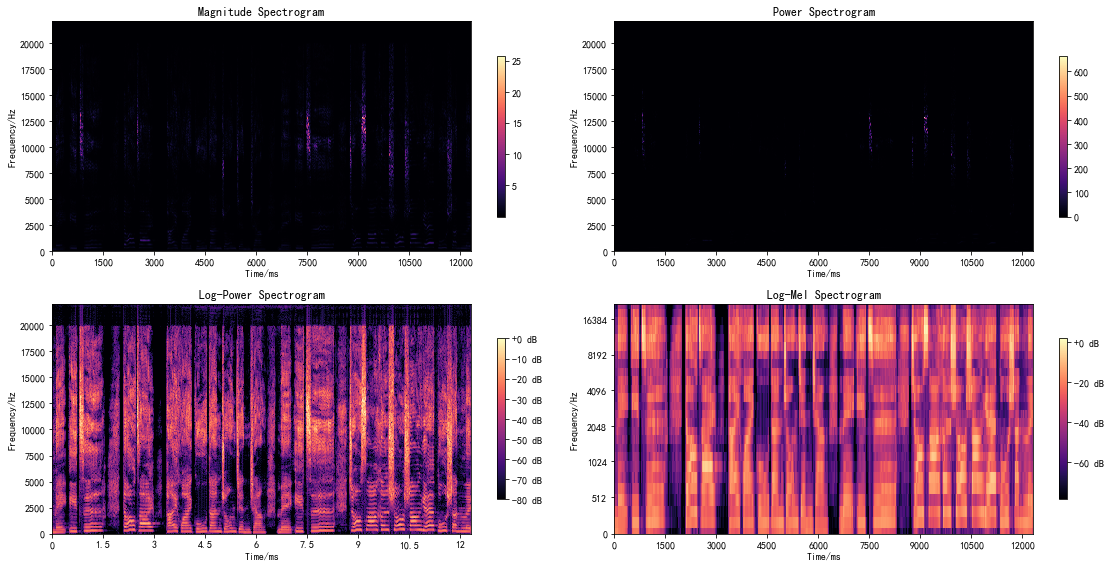

In [25]:
# 声谱图特征
spectrogram_f = Spectrogram(wave_file_vad)
spectrogram_f.plot()